In [1]:
%matplotlib inline  
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import matplotlib
import matplotlib.dates as mdates
from matplotlib.dates import MonthLocator, WeekdayLocator, DateFormatter
from dateutil.relativedelta import relativedelta 
from matplotlib.ticker import MaxNLocator
from matplotlib.backends.backend_pdf import PdfPages

In [23]:
# Goal for this project is to be able to print out a "yearly report" based on MP ticks plus the ones I input myself.
# It contains pyramids (for trad, sport and bouldering) for just the year and for all-time: 
# Pyramids include redpoint/total, 1st go, 2nd go. (No 2nd go for bouldering)

# NOTES: 
#- Still need to convert slash boulder grades to slashes as opposed to -'s'


# import csv file 

fileName = 'notonMPticks.csv'
df = pd.read_csv( fileName, parse_dates=['Date'])

In [24]:
# Creating a function that takes the string 'Rating' and converts it to a numeric grade
# Going to have one for boulders and one for routes. 
# For ease and practicality going to just group all routes less than 10a into one group. 

def converter_routes(route):
    a = route.split('.')
    b = a[1].split()[0]   # Dealing with safety ratings: PG, PG13, R 
    b = b.split('/')[0]   # Dealing with slash grades. Just going with lesser. 
    
    
    b = b.replace("a",".00")
    b = b.replace("b",".25")  
    b = b.replace("c",".5")    
    b = b.replace("d",".75")
    b = b.replace("+",".75")
    b = b.replace("-",".00")
    
    if float(b) < 10.00: 
        return float(9)
    else: 
        return float(b)
    
def converter_boulders(boulder):
    
    b = boulder.split()[0] # Dealing with safety ratings: PG, PG13, R 
 
    b = b.replace("V", "")
    b = b.replace("+",".32")
    
    if b.find("-") != -1: 
        b = b.replace("-","")
        b = float(b)- .32
      
        return(b)
        
    elif b.find("/") != -1: # Dealing with slash grades. 7/8 = 7+  
        b = float(b.split("/")[0]) + .32

        return float(b)
        
    else :
      
        return float(b)

In [25]:
# convert date column to a useable format.

df['Date'] = pd.to_datetime(df['Date'])  
cols = df.columns.tolist()  

# convert Hueco/yds scale to numeric values. I'm doing no slash or +/- grades. So adjust as needed. 
df['numeric_grade']= 0  # initialize grade column 

for index, row in df.iterrows():
    a = df.loc[index,'Rating']  
       
    if a[0] == "V": # Boulders 
        df.loc[index,'numeric_grade'] = converter_boulders(a)

    else: #Trad and Sport
        df.loc[index,'numeric_grade'] = converter_routes(a)
        

In [26]:
# Here I am using the notes to make a ''# of goes' column. Pretty Lit. Remember to include that in MPnotes!
# Record your goes!! 
# Also only record a single tick in MP for climbs. I don't currently have a way to get rid of repeat recordings.

df['numeric_goes'] = 100 
for index, row in df.iterrows():
    
    l = str(df.loc[index,'Notes'])
  
    if df.loc[index, 'Lead Style'] == 'Onsight':  # The Flash/Onsight demarcation comes up in Lead Style or Style
        df.loc[index,'numeric_goes'] = .5     
    if df.loc[index, 'Style'] == 'Onsight':
        df.loc[index,'numeric_goes'] = .5           
    if df.loc[index, 'Lead Style'] == 'Flash':
        df.loc[index,'numeric_goes'] = 1 
    if df.loc[index, 'Style'] == 'Flash':
        df.loc[index,'numeric_goes'] = 1 
    if l.find('2nd go') != -1 :
        df.loc[index,'numeric_goes'] = 2 
    if l.find('3rd go') != -1 :
        df.loc[index,'numeric_goes'] = 3     
    if l.find('4th go') != -1 :
        df.loc[index,'numeric_goes'] = 4   
    if l.find('5th go') != -1 :
        df.loc[index,'numeric_goes'] = 5 
    if l.find('6th go') != -1 :
        df.loc[index,'numeric_goes'] = 6 
    if l.find('7th go') != -1 :
        df.loc[index,'numeric_goes'] = 7 
    if l.find('8th go') != -1 :
        df.loc[index,'numeric_goes'] = 8 
    if l.find('9th go') != -1 :
        df.loc[index,'numeric_goes'] = 9 
    if l.find('10th go') != -1 :
        df.loc[index,'numeric_goes'] = 10 
    if l.find('11th go') != -1 :
        df.loc[index,'numeric_goes'] = 11 
    if l.find('12th go') != -1 :
        df.loc[index,'numeric_goes'] = 12 
    if l.find('13th go') != -1 :
        df.loc[index,'numeric_goes'] = 13 
    if l.find('14th go') != -1 :
        df.loc[index,'numeric_goes'] = 14
    if l.find('15th go') != -1 :
        df.loc[index,'numeric_goes'] = 15
    if l.find('16th go') != -1 :
        df.loc[index,'numeric_goes'] = 16 
    if l.find('17th go') != -1 :
        df.loc[index,'numeric_goes'] = 17
   


In [27]:
#Useful Functions 

# Range Function for grades.
def frange(start, stop, step):
    a = []
    i = start
    while i < stop : 
        a.append(i) 
        i += step
    return a 

# A function that outputs a pyramid based on discipline and year and 'goes' range
def rope_plotter(discipline, year, goes_min, goes_max, df):
  
    if year == 0:
        a = df[(df['Route Type']== discipline) & (df['numeric_goes']> goes_min)& (df['numeric_goes']< goes_max) ]['numeric_grade'].to_numpy()
        year = 'All Time'
    else:   
        a = df[(df['Route Type']== discipline) & (df['numeric_goes']> goes_min)& (df['numeric_goes']< goes_max)& (df['Date'].dt.year == year) ]['numeric_grade'].to_numpy()
    
    grades = frange(10,14.25,.25)
    
    # Histogramming. Outputs will be n1, b1 

     
    return np.histogram(a, bins = grades)

# A function that outputs a boulder pyramid based on year, number of tries for boulders. Of varying size.  

def boulder_plotter(year, goes_min, goes_max, df):
    numba = 'blah'
    
    if goes_min == 0 and goes_max == 1.1 :
        numba = 'Flash/Onsight'
    if goes_min == 0 and goes_max == 101 :
        numba = 'Redpoint'
    if year == 0: 
        a = df[(df['Route Type']== 'Boulder')& (df['numeric_goes']> goes_min)& (df['numeric_goes']< goes_max) ]['numeric_grade'].to_numpy()
        year = 'All Time'
    else: 
        a = df[(df['Route Type']== 'Boulder')& (df['numeric_goes']> goes_min)& (df['numeric_goes']< goes_max) & (df['Date'].dt.year == year) ]['numeric_grade'].to_numpy()
    
    grades = frange(2.67,13.33,1)
    grades_shift = frange(3,14,1)
    
    return np.histogram(a, bins =grades)
    



In [96]:

def yearly_report(year):
    
    pp = PdfPages('{}Pyramids.pdf'.format(year))
    
            # -------Boulder PYRAMIDS -------------#
    
    # -------All Time Boulder PYRAMID -------------#
    fig5, ax5 = plt.subplots(1, figsize=(7,4))
    
    grades = frange(2.67,13.33,1)
    
    
    boulder_hist_all, boulder_bins_all = boulder_plotter(0, 0, 101, df)  
    boulder_hist_all_firstgo, boulder_hist_all_firstgo_bins = boulder_plotter(0, 0, 1.1, df)
   
    
    ax5.barh(boulder_bins_all[:-1],boulder_hist_all,0.7,label="Send")
    ax5.barh(boulder_hist_all_firstgo_bins[:-1],boulder_hist_all_firstgo,0.7,label="Onsight/Flash")
 

    plt.title( "All-Time Boulder Pyramid") 
    ax5.set_yticks(grades)
    ax5.set_yticklabels((['V3','V4','V5','V6','V7','V8','V9','V10','V11','V12','V13']))
    ax5.legend()
    for i, a in enumerate(boulder_hist_all):
        if a!= 0:
            ax5.text(a + max(boulder_hist_all)/30, grades[i],str(a),ha='center', va='center', color='black')    
    plt.tight_layout()

    pp.savefig(fig5) 
    plt.show()

    # -------YEARLY Boulder PYRAMID -------------#
    fig6, ax6 = plt.subplots(1, figsize=(7,4))
    
    grades = frange(2.67,13.33,1)
    
    
    boulder_hist_year, boulder_hist_year_bins = boulder_plotter(year, 0, 101, df)  
    boulder_hist_year_firstgo, boulder_hist_year_firstgo_bins = boulder_plotter(year, 0, 1.1, df)
    
    
    ax6.barh(boulder_hist_year_bins[:-1],boulder_hist_year,0.7,label="Send")
    ax6.barh(boulder_hist_year_firstgo_bins[:-1],boulder_hist_year_firstgo,0.7,label="Onsight/Flash")
    

    plt.title( "{} Boulder Pyramid".format(year)) 
    ax6.set_yticks(grades)
    ax6.set_yticklabels((['V3','V4','V5','V6','V7','V8','V9','V10','V11','V12','V13']))
    ax6.legend()
    for i, a in enumerate(boulder_hist_year):
        if a!= 0:
            ax6.text(a + max(boulder_hist_year)/30, grades[i],str(a),ha='center', va='center', color='black')    
    plt.tight_layout()

    pp.savefig(fig6) 
    # -------SPORT PYRAMIDS -------------#
    
    # -------All Time Sport PYRAMID -------------#
    fig1, ax1 = plt.subplots(1, figsize=(7,4))
    
    grades = frange(10,14.25,.25)

    sport_hist_all, sport_hist_all_bins = rope_plotter('Sport',0, 0, 101, df)  
    sport_hist_all_firstgo, sport_hist_all_firstgo_bins = rope_plotter('Sport',0, 0, 1.1, df)
    sport_hist_all_secondgo, sport_hist_all_secondgo_bins = rope_plotter('Sport',0, 1.9, 2.1, df)
    
    ax1.barh(sport_hist_all_bins[:-1],sport_hist_all,0.2,label="Redpoint")
    ax1.barh(sport_hist_all_firstgo_bins[:-1],sport_hist_all_firstgo,0.2,label="Onsight/Flash")
    ax1.barh(sport_hist_all_secondgo_bins[:-1],sport_hist_all_secondgo, 0.2,left = sport_hist_all_firstgo,label="2nd Go") # How to get this to show up right?

    plt.title( "All-Time Sport Pyramid") 
    ax1.set_yticks(grades)
    ax1.set_yticklabels((['5.10a','5.10b','5.10c','5.10d','5.11a','5.11b','5.11c','5.11d','5.12a','5.12b','5.12c','5.12d','5.13a','5.13b','5.13c','5.13d','5.14a' ]))
    ax1.legend()
    
    for i, a in enumerate(sport_hist_all):
        if a!= 0:
            ax1.text(a + max(sport_hist_all)/30, grades[i],str(a),ha='center', va='center', color='black')    
    plt.tight_layout()

    pp.savefig(fig1) 
    plt.show()

    # -------YEARLY Sport PYRAMID -------------#
    fig2, ax2 = plt.subplots(1, figsize=(7,4))
    
    grades = frange(10,14.25,.25)

    sport_hist_year, sport_hist_year_bins = rope_plotter('Sport',year, 0, 101, df)  
    sport_hist_year_firstgo, sport_hist_year_firstgo_bins = rope_plotter('Sport',year, 0, 1.1, df)
    sport_hist_year_secondgo, sport_hist_year_secondgo_bins = rope_plotter('Sport',year, 1.9, 2.1, df)
    
    ax2.barh(sport_hist_year_bins[:-1],sport_hist_year,0.2,label="Redpoint")
    ax2.barh(sport_hist_year_firstgo_bins[:-1],sport_hist_year_firstgo,0.2,label="Onsight/Flash")
    ax2.barh(sport_hist_year_secondgo_bins[:-1],sport_hist_year_secondgo, 0.2,left = sport_hist_year_firstgo,label="2nd Go")

    plt.title( "{} Sport Pyramid".format(year)) 
    ax2.set_yticks(grades)
    ax2.set_yticklabels((['5.10a','5.10b','5.10c','5.10d','5.11a','5.11b','5.11c','5.11d','5.12a','5.12b','5.12c','5.12d','5.13a','5.13b','5.13c','5.13d','5.14a' ]))
    ax2.legend()
    
    for i, a in enumerate(sport_hist_year):
        if a!= 0:
            ax2.text(a + max(sport_hist_year)/30, grades[i],str(a),ha='center', va='center', color='black')    
    plt.tight_layout()

    pp.savefig(fig2) 
    plt.show()
    
    # -------TRAD PYRAMIDS -------------#
    
    # -------All Time TRAD PYRAMID -------------#
    fig3, ax3 = plt.subplots(1, figsize=(7,4))
    
    grades = frange(10,14.25,.25)
 
    
    
    trad_hist_all, trad_hist_all_bins = rope_plotter('Trad',0, 0, 101, df)  
    trad_hist_all_firstgo, trad_hist_all_firstgo_bins = rope_plotter('Trad',0, 0, 1.1, df)
    trad_hist_all_secondgo, trad_hist_all_secondgo_bins = rope_plotter('Trad',0, 1.9, 2.1, df)
    
    ax3.barh(trad_hist_all_bins[:-1],trad_hist_all,0.2,label="Redpoint")
    ax3.barh(trad_hist_all_firstgo_bins[:-1],trad_hist_all_firstgo,0.2,label="Onsight/Flash")
    ax3.barh(trad_hist_all_secondgo_bins[:-1],trad_hist_all_secondgo, 0.2,left = trad_hist_all_firstgo,label="2nd Go")

    plt.title( "All-Time Trad Pyramid") 
    ax3.set_yticks(grades)
    ax3.set_yticklabels((['5.10a','5.10b','5.10c','5.10d','5.11a','5.11b','5.11c','5.11d','5.12a','5.12b','5.12c','5.12d','5.13a','5.13b','5.13c','5.13d','5.14a' ]))
    ax3.legend()
    for i, a in enumerate(trad_hist_all):
        if a!= 0:
            ax3.text(a + max(trad_hist_all)/30, grades[i],str(a),ha='center', va='center', color='black')    
    plt.tight_layout()

    pp.savefig(fig3) 
    plt.show()

    # -------YEARLY TRAD PYRAMID -------------#
    fig4, ax4 = plt.subplots(1, figsize=(7,4))
    
    grades = frange(10,14.25,.25)
    grades_shift = frange(10.125,14.375,.25)
    
    
    trad_hist_year, trad_hist_year_bins = rope_plotter('Trad',year, 0, 101, df)  
    trad_hist_year_firstgo, trad_hist_year_firstgo_bins = rope_plotter('Trad',year, 0, 1.1, df)
    trad_hist_year_secondgo, trad_hist_year_secondgo_bins = rope_plotter('Trad',year, 1.9, 2.1, df)
    
    ax4.barh(trad_hist_year_bins[:-1],trad_hist_year,0.2,label="Redpoint")
    ax4.barh(trad_hist_year_firstgo_bins[:-1],trad_hist_year_firstgo,0.2,label="Onsight/Flash")
    ax4.barh(trad_hist_year_secondgo_bins[:-1],trad_hist_year_secondgo, 0.2,left = trad_hist_year_firstgo,label="2nd Go")

    plt.title( "{} Trad Pyramid".format(year)) 
    ax4.set_yticks(grades)
    ax4.set_yticklabels((['5.10a','5.10b','5.10c','5.10d','5.11a','5.11b','5.11c','5.11d','5.12a','5.12b','5.12c','5.12d','5.13a','5.13b','5.13c','5.13d','5.14a' ]))
    ax4.legend()
    for i, a in enumerate(trad_hist_year):
        if a!= 0:
            ax4.text(a + max(trad_hist_year)/30, grades[i],str(a),ha='center', va='center', color='black')    
    plt.tight_layout()

    pp.savefig(fig4) 
    # Here I will print out some numbers relavant to the 'By 30 Goals' 
    
    
    # Sport: 

#     -Climb 20 5.13’s total 
    thirteens = np.sum(sport_hist_all[12:16])
#     -Climb 100 5.12’s total 
    twelves = np.sum(sport_hist_all[8:12])
    
    # Boulder: 
    
#     -Climb 20 v9 or harder
    vnineorharder = np.sum(boulder_hist_all[6:11])
#     -Climb 80 v6-v8 total 
    vsixtoeight = np.sum(boulder_hist_all[3:6])

    # Trad: 
    
#     -Climb 20 5.11’s total 
    tradeleven = np.sum(trad_hist_all[4:8])
#     -Climb 50 5.10’s total 
    tradten = np.sum(trad_hist_all[0:4])
    
    
    firstPage = plt.figure(figsize=(11.69,8.27))
    firstPage.clf()
    txt2 = 'Sport: {} 13s and {} 12s. Boulder: {} v9 or harder. {} v6-v8. '.format(thirteens, twelves,vnineorharder,vsixtoeight)
    txt1 = 'Trad: {} 11s and {} 10s.'.format(tradeleven,tradten)
    firstPage.text(0.5,0.5,txt1, transform=firstPage.transFigure, size=24, ha="center", va = 'top')
    firstPage.text(0.5,0.5,txt2, transform=firstPage.transFigure, size=24, ha="center", va = 'bottom')
    
    pp.savefig()
    plt.show()
    pp.close()  # Closing up the PDF report. 
    
    



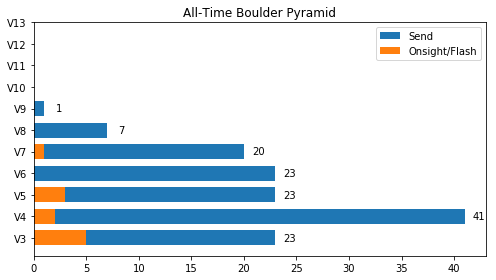

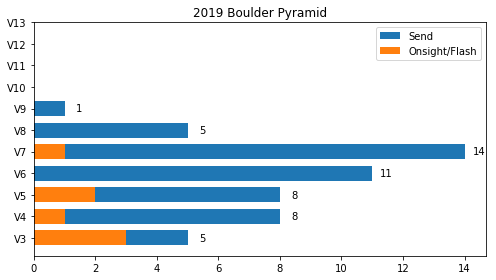

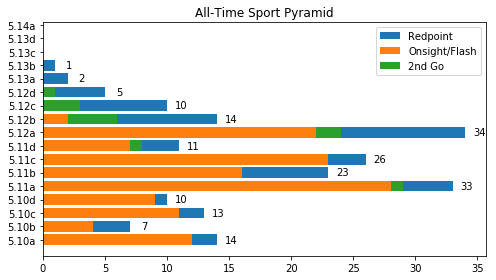

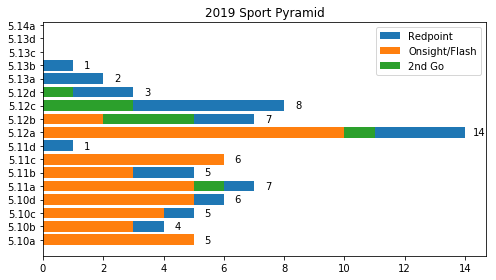

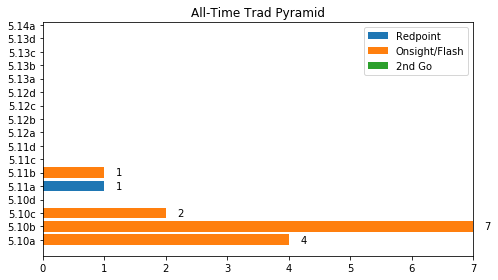

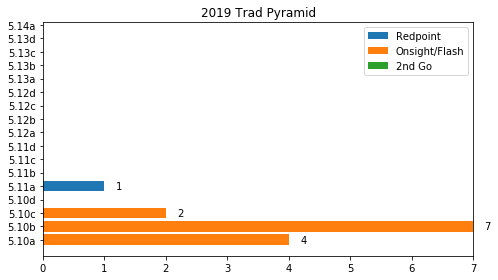

<Figure size 841.68x595.44 with 0 Axes>

In [97]:
# Here I just run the above function to create the report. Change the year as necessary. 

yearly_report(2019)

In [ ]:
# Debugging: 

# issue # 1: Why does my v7 flash of danny devito not come up? 
# Fixed it. It was because I had my max 'numeric_grade' set to 1 not 1.1! 


# a = df[(df['numeric_goes']< 1.1) & (df['numeric_grade'] < 10)]
# print(a)

# Something is wrong with numeric_goes

# Issue 2: Did I climb no trad in 2018? 

# You did but nothing harder than 5.9
# Here is how to put a df into a csv to look at a bit more easily: 

# export_csv = df.to_csv (r'export_dataframe.csv', index = None, header=True) 

In [ ]:
# Project Notes: 
    
#     - I need to now also start keeping things I don't put in MP in this format! And change what I do have 
#      to match it. 
#     - Prepare for a post to r\climbharder. A year of climbing and training in review. 
#     - Comment it up so someone could potentially use it. 
